In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os


In [2]:
import joblib
import pandas as pd

data_kcat = joblib.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/dataset/kcat_with_features.joblib')
data_kcat.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,reactant_smiles,product_smiles,log10kcat_max,metabolite_features,protein_features
0,MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...,sabio,Q05469,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O>>CCC(=O)O.CCC(...,7.00,3.1.1.1,0.845098,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O,CCC(=O)O.CCC(=O)OCC(CO)OC(=O)CC,0.845098,"[0.25240317, -0.45278314, -0.76844007, 0.04716...","[-0.06076221, -0.21264695, -0.05684641, 0.0163..."
1,MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...,brenda,Q71RI9,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,1.48,2.6.1.7,0.170262,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,N[C@@H](Cc1ccc(O)cc1)C(=O)O.O=C(O)c1cc(=O)c2cc...,0.170262,"[0.066915624, -0.15937805, -0.7076091, 0.12864...","[-0.051194582, -0.07116077, 0.16383636, 0.2113..."
2,MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...,brenda,A2SL37,C/C(=C\C=C(/O)C(=O)O)C(=O)O>>CC(/C=C/C(=O)C(=O...,3.40,5.3.2.6,0.531479,C/C(=C\C=C(/O)C(=O)O)C(=O)O,CC(/C=C/C(=O)C(=O)O)C(=O)O,2.029384,"[0.23911352, 0.011175589, -0.35101113, 0.15938...","[-0.1772431, -0.06500952, 0.18246448, -0.05431..."
3,MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...,brenda,Q9X015,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,0.69,3.6.1.9,-0.161151,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,-0.161151,"[0.078591675, -0.15656142, -0.55292135, -0.245...","[-0.09246727, -0.033019878, 0.10869139, 0.2953..."
4,MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...,sabio,P0A7B1,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,420.00,2.7.4.1,2.623249,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O...,2.623249,"[0.00051207165, -0.7151457, -0.95394605, -0.15...","[-0.06592023, -0.062496405, -0.012068139, 0.06..."


In [3]:
data_kcat.rename(columns={'log10kcat_max':'label'},inplace=True)
data_kcat.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,reactant_smiles,product_smiles,label,metabolite_features,protein_features
0,MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...,sabio,Q05469,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O>>CCC(=O)O.CCC(...,7.00,3.1.1.1,0.845098,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O,CCC(=O)O.CCC(=O)OCC(CO)OC(=O)CC,0.845098,"[0.25240317, -0.45278314, -0.76844007, 0.04716...","[-0.06076221, -0.21264695, -0.05684641, 0.0163..."
1,MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...,brenda,Q71RI9,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,1.48,2.6.1.7,0.170262,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,N[C@@H](Cc1ccc(O)cc1)C(=O)O.O=C(O)c1cc(=O)c2cc...,0.170262,"[0.066915624, -0.15937805, -0.7076091, 0.12864...","[-0.051194582, -0.07116077, 0.16383636, 0.2113..."
2,MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...,brenda,A2SL37,C/C(=C\C=C(/O)C(=O)O)C(=O)O>>CC(/C=C/C(=O)C(=O...,3.40,5.3.2.6,0.531479,C/C(=C\C=C(/O)C(=O)O)C(=O)O,CC(/C=C/C(=O)C(=O)O)C(=O)O,2.029384,"[0.23911352, 0.011175589, -0.35101113, 0.15938...","[-0.1772431, -0.06500952, 0.18246448, -0.05431..."
3,MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...,brenda,Q9X015,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,0.69,3.6.1.9,-0.161151,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,-0.161151,"[0.078591675, -0.15656142, -0.55292135, -0.245...","[-0.09246727, -0.033019878, 0.10869139, 0.2953..."
4,MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...,sabio,P0A7B1,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,420.00,2.7.4.1,2.623249,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O...,2.623249,"[0.00051207165, -0.7151457, -0.95394605, -0.15...","[-0.06592023, -0.062496405, -0.012068139, 0.06..."


In [4]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [5]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data_kcat, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [6]:
import torch.nn as nn
import torch

# Define Diffusion Generative Model for Regression
class DiffusionGenerativeModel(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, hidden_dim, num_timesteps):
        super(DiffusionGenerativeModel, self).__init__()
        self.num_timesteps = num_timesteps
        self.mol_encoder = nn.Linear(mol_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.denoise_model = nn.Linear(hidden_dim * 2, hidden_dim)
        self.regressor = nn.Linear(hidden_dim, 1)  # Regression layer
        self.activation = nn.ReLU()

        # Embedding for timesteps
        self.timestep_embedding = nn.Embedding(num_timesteps, hidden_dim * 2)

    def forward(self, mol_features, protein_features, t):
        # Encode mol and protein features
        mol_embedding = self.activation(self.mol_encoder(mol_features))
        protein_embedding = self.activation(self.protein_encoder(protein_features))

        # Concatenate embeddings
        combined = torch.cat((mol_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Add learnable timestep embedding
        t_embedding = self.timestep_embedding(t.long())
        combined += t_embedding

        # Denoise process
        denoised = self.activation(self.denoise_model(combined))

        # Regression layer
        output = self.regressor(denoised)  # Predict continuous values
        return output

    def add_noise(self, x, noise_level=0.1):
        noise = noise_level * torch.randn_like(x)
        return x + noise


In [7]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr

train_history = pd.DataFrame(columns=[ 'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = DiffusionGenerativeModel(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim, hidden_dim=512, num_timesteps=num_timesteps)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        # Add noise to the features
        noisy_mol_features = model.add_noise(mol_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        optimizer.zero_grad()
        outputs = model(noisy_mol_features, noisy_protein_features, torch.randint(0, num_timesteps, (mol_features.size(0),)).to(device)).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()
    train_rmse = torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2).mean().item()
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(np.array(train_labels), np.array(train_predictions))
    train_median_ae = median_absolute_error(np.array(train_labels), np.array(train_predictions))
    train_explained_var = explained_variance_score(np.array(train_labels), np.array(train_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            # Add noise to the features
            noisy_mol_features = model.add_noise(mol_features, noise_level=0.1)
            noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

            outputs = model(noisy_mol_features, noisy_protein_features, torch.randint(0, num_timesteps, (mol_features.size(0),)).to(device)).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()
    val_rmse = torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(np.array(val_labels), np.array(val_predictions))
    val_explained_var = explained_variance_score(np.array(val_labels), np.array(val_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)

# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        # Add noise to the features
        noisy_mol_features = model.add_noise(mol_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        outputs = model(noisy_mol_features, noisy_protein_features, torch.randint(0, num_timesteps, (mol_features.size(0),)).to(device)).squeeze()
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = torch.sqrt((torch.tensor(test_predictions) - torch.tensor(test_labels)) ** 2).mean().item()
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")


Training Epoch 1: 100%|██████████| 507/507 [00:03<00:00, 160.29it/s]


Epoch 0 - Train Loss: 2.6371, Train MSE: 2.6376, Train MAE: 1.2442


/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_16850/374893312.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Validation Loss: 2.4457, Validation MSE: 2.4446, Validation MAE: 1.2031


Training Epoch 11: 100%|██████████| 507/507 [00:06<00:00, 80.80it/s] 


Epoch 10 - Train Loss: 2.0350, Train MSE: 2.0347, Train MAE: 1.0756
Epoch 10 - Validation Loss: 2.0354, Validation MSE: 2.0348, Validation MAE: 1.0934


Training Epoch 21: 100%|██████████| 507/507 [00:04<00:00, 111.15it/s]


Epoch 20 - Train Loss: 1.8070, Train MSE: 1.8057, Train MAE: 1.0180
Epoch 20 - Validation Loss: 1.8733, Validation MSE: 1.8735, Validation MAE: 1.0441


Training Epoch 31: 100%|██████████| 507/507 [00:05<00:00, 97.67it/s] 


Epoch 30 - Train Loss: 1.6441, Train MSE: 1.6432, Train MAE: 0.9688
Epoch 30 - Validation Loss: 1.8139, Validation MSE: 1.8152, Validation MAE: 1.0288


Training Epoch 41: 100%|██████████| 507/507 [00:04<00:00, 103.24it/s]


Epoch 40 - Train Loss: 1.4978, Train MSE: 1.4984, Train MAE: 0.9242
Epoch 40 - Validation Loss: 1.7268, Validation MSE: 1.7295, Validation MAE: 0.9962


Training Epoch 51: 100%|██████████| 507/507 [00:05<00:00, 94.41it/s] 


Epoch 50 - Train Loss: 1.3999, Train MSE: 1.4000, Train MAE: 0.8963
Epoch 50 - Validation Loss: 1.6802, Validation MSE: 1.6826, Validation MAE: 0.9754


Training Epoch 61: 100%|██████████| 507/507 [00:05<00:00, 94.73it/s] 


Epoch 60 - Train Loss: 1.3061, Train MSE: 1.3058, Train MAE: 0.8650
Epoch 60 - Validation Loss: 1.7064, Validation MSE: 1.7111, Validation MAE: 0.9875


Training Epoch 71: 100%|██████████| 507/507 [00:05<00:00, 90.01it/s] 


Epoch 70 - Train Loss: 1.2374, Train MSE: 1.2357, Train MAE: 0.8408
Epoch 70 - Validation Loss: 1.6075, Validation MSE: 1.6095, Validation MAE: 0.9549


Training Epoch 81: 100%|██████████| 507/507 [00:05<00:00, 95.43it/s] 


Epoch 80 - Train Loss: 1.1714, Train MSE: 1.1686, Train MAE: 0.8166
Epoch 80 - Validation Loss: 1.6077, Validation MSE: 1.6113, Validation MAE: 0.9539


Training Epoch 91: 100%|██████████| 507/507 [00:06<00:00, 82.50it/s]


Epoch 90 - Train Loss: 1.1168, Train MSE: 1.1168, Train MAE: 0.7984
Epoch 90 - Validation Loss: 1.5888, Validation MSE: 1.5919, Validation MAE: 0.9453


Training Epoch 101: 100%|██████████| 507/507 [00:06<00:00, 76.17it/s]


Epoch 100 - Train Loss: 1.0600, Train MSE: 1.0604, Train MAE: 0.7751
Epoch 100 - Validation Loss: 1.5871, Validation MSE: 1.5902, Validation MAE: 0.9424


Training Epoch 111: 100%|██████████| 507/507 [00:06<00:00, 76.51it/s]


Epoch 110 - Train Loss: 1.0027, Train MSE: 1.0017, Train MAE: 0.7580
Epoch 110 - Validation Loss: 1.5615, Validation MSE: 1.5643, Validation MAE: 0.9357


Training Epoch 121: 100%|██████████| 507/507 [00:06<00:00, 76.13it/s]


Epoch 120 - Train Loss: 0.9516, Train MSE: 0.9520, Train MAE: 0.7381
Epoch 120 - Validation Loss: 1.5710, Validation MSE: 1.5736, Validation MAE: 0.9303


Training Epoch 131: 100%|██████████| 507/507 [00:06<00:00, 75.72it/s]


Epoch 130 - Train Loss: 0.9288, Train MSE: 0.9287, Train MAE: 0.7290
Epoch 130 - Validation Loss: 1.5489, Validation MSE: 1.5524, Validation MAE: 0.9244


Training Epoch 141: 100%|██████████| 507/507 [00:05<00:00, 89.01it/s]


Epoch 140 - Train Loss: 0.8996, Train MSE: 0.8996, Train MAE: 0.7163
Epoch 140 - Validation Loss: 1.5139, Validation MSE: 1.5172, Validation MAE: 0.9175


Training Epoch 151: 100%|██████████| 507/507 [00:04<00:00, 105.52it/s]


Epoch 150 - Train Loss: 0.8824, Train MSE: 0.8824, Train MAE: 0.7083
Epoch 150 - Validation Loss: 1.5069, Validation MSE: 1.5102, Validation MAE: 0.9156


Training Epoch 161: 100%|██████████| 507/507 [00:04<00:00, 103.57it/s]


Epoch 160 - Train Loss: 0.8171, Train MSE: 0.8171, Train MAE: 0.6875
Epoch 160 - Validation Loss: 1.5497, Validation MSE: 1.5528, Validation MAE: 0.9196


Training Epoch 171: 100%|██████████| 507/507 [00:04<00:00, 105.85it/s]


Epoch 170 - Train Loss: 0.8198, Train MSE: 0.8192, Train MAE: 0.6847
Epoch 170 - Validation Loss: 1.5464, Validation MSE: 1.5501, Validation MAE: 0.9223


Training Epoch 181: 100%|██████████| 507/507 [00:04<00:00, 107.70it/s]


Epoch 180 - Train Loss: 0.7900, Train MSE: 0.7896, Train MAE: 0.6724
Epoch 180 - Validation Loss: 1.5119, Validation MSE: 1.5145, Validation MAE: 0.9171


Training Epoch 191: 100%|██████████| 507/507 [00:04<00:00, 105.30it/s]


Epoch 190 - Train Loss: 0.7799, Train MSE: 0.7803, Train MAE: 0.6642
Epoch 190 - Validation Loss: 1.5234, Validation MSE: 1.5255, Validation MAE: 0.9155


Training Epoch 201: 100%|██████████| 507/507 [00:04<00:00, 103.28it/s]


Epoch 200 - Train Loss: 0.7486, Train MSE: 0.7488, Train MAE: 0.6528
Epoch 200 - Validation Loss: 1.4792, Validation MSE: 1.4817, Validation MAE: 0.8990


Training Epoch 211: 100%|██████████| 507/507 [00:04<00:00, 103.89it/s]


Epoch 210 - Train Loss: 0.7257, Train MSE: 0.7248, Train MAE: 0.6452
Epoch 210 - Validation Loss: 1.5006, Validation MSE: 1.5046, Validation MAE: 0.9135


Training Epoch 221: 100%|██████████| 507/507 [00:04<00:00, 105.55it/s]


Epoch 220 - Train Loss: 0.7253, Train MSE: 0.7253, Train MAE: 0.6429
Epoch 220 - Validation Loss: 1.4589, Validation MSE: 1.4616, Validation MAE: 0.8904


Training Epoch 231: 100%|██████████| 507/507 [00:04<00:00, 104.92it/s]


Epoch 230 - Train Loss: 0.6914, Train MSE: 0.6912, Train MAE: 0.6273
Epoch 230 - Validation Loss: 1.4737, Validation MSE: 1.4769, Validation MAE: 0.8984


Training Epoch 241: 100%|██████████| 507/507 [00:05<00:00, 95.43it/s] 


Epoch 240 - Train Loss: 0.6872, Train MSE: 0.6865, Train MAE: 0.6282
Epoch 240 - Validation Loss: 1.4887, Validation MSE: 1.4899, Validation MAE: 0.9013


Training Epoch 251: 100%|██████████| 507/507 [00:05<00:00, 89.77it/s] 


Epoch 250 - Train Loss: 0.6733, Train MSE: 0.6727, Train MAE: 0.6179
Epoch 250 - Validation Loss: 1.5063, Validation MSE: 1.5092, Validation MAE: 0.9047


Training Epoch 261: 100%|██████████| 507/507 [00:05<00:00, 96.15it/s] 


Epoch 260 - Train Loss: 0.6657, Train MSE: 0.6661, Train MAE: 0.6123
Epoch 260 - Validation Loss: 1.4933, Validation MSE: 1.4970, Validation MAE: 0.8985


Training Epoch 271: 100%|██████████| 507/507 [00:05<00:00, 85.19it/s]


Epoch 270 - Train Loss: 0.6393, Train MSE: 0.6396, Train MAE: 0.6039
Epoch 270 - Validation Loss: 1.4941, Validation MSE: 1.4974, Validation MAE: 0.8920


Training Epoch 281: 100%|██████████| 507/507 [00:05<00:00, 85.62it/s]


Epoch 280 - Train Loss: 0.6310, Train MSE: 0.6310, Train MAE: 0.5953
Epoch 280 - Validation Loss: 1.4674, Validation MSE: 1.4704, Validation MAE: 0.8893


Training Epoch 291: 100%|██████████| 507/507 [00:05<00:00, 87.72it/s]


Epoch 290 - Train Loss: 0.6189, Train MSE: 0.6190, Train MAE: 0.5932
Epoch 290 - Validation Loss: 1.4435, Validation MSE: 1.4451, Validation MAE: 0.8794


Training Epoch 301: 100%|██████████| 507/507 [00:05<00:00, 89.86it/s]


Epoch 300 - Train Loss: 0.6088, Train MSE: 0.6092, Train MAE: 0.5884
Epoch 300 - Validation Loss: 1.4581, Validation MSE: 1.4598, Validation MAE: 0.8877


Training Epoch 311: 100%|██████████| 507/507 [00:05<00:00, 89.47it/s]


Epoch 310 - Train Loss: 0.5929, Train MSE: 0.5931, Train MAE: 0.5798
Epoch 310 - Validation Loss: 1.4712, Validation MSE: 1.4743, Validation MAE: 0.8929


Training Epoch 321: 100%|██████████| 507/507 [00:05<00:00, 87.98it/s]


Epoch 320 - Train Loss: 0.6001, Train MSE: 0.6003, Train MAE: 0.5829
Epoch 320 - Validation Loss: 1.4520, Validation MSE: 1.4537, Validation MAE: 0.8843


Training Epoch 331: 100%|██████████| 507/507 [00:05<00:00, 90.37it/s]


Epoch 330 - Train Loss: 0.5942, Train MSE: 0.5940, Train MAE: 0.5795
Epoch 330 - Validation Loss: 1.4778, Validation MSE: 1.4804, Validation MAE: 0.8922


Training Epoch 341: 100%|██████████| 507/507 [00:05<00:00, 86.33it/s]


Epoch 340 - Train Loss: 0.5773, Train MSE: 0.5774, Train MAE: 0.5726
Epoch 340 - Validation Loss: 1.4777, Validation MSE: 1.4814, Validation MAE: 0.8925


Training Epoch 351: 100%|██████████| 507/507 [00:05<00:00, 87.72it/s]


Epoch 350 - Train Loss: 0.5557, Train MSE: 0.5560, Train MAE: 0.5593
Epoch 350 - Validation Loss: 1.4792, Validation MSE: 1.4827, Validation MAE: 0.8939


Training Epoch 361: 100%|██████████| 507/507 [00:05<00:00, 89.19it/s]


Epoch 360 - Train Loss: 0.5635, Train MSE: 0.5638, Train MAE: 0.5675
Epoch 360 - Validation Loss: 1.4656, Validation MSE: 1.4679, Validation MAE: 0.8811


Training Epoch 371: 100%|██████████| 507/507 [00:05<00:00, 89.02it/s]


Epoch 370 - Train Loss: 0.5565, Train MSE: 0.5562, Train MAE: 0.5605
Epoch 370 - Validation Loss: 1.4589, Validation MSE: 1.4625, Validation MAE: 0.8840


Training Epoch 381: 100%|██████████| 507/507 [00:05<00:00, 90.16it/s]


Epoch 380 - Train Loss: 0.5513, Train MSE: 0.5517, Train MAE: 0.5588
Epoch 380 - Validation Loss: 1.4668, Validation MSE: 1.4702, Validation MAE: 0.8793


Training Epoch 391: 100%|██████████| 507/507 [00:05<00:00, 90.44it/s] 


Epoch 390 - Train Loss: 0.5446, Train MSE: 0.5448, Train MAE: 0.5547
Epoch 390 - Validation Loss: 1.4451, Validation MSE: 1.4480, Validation MAE: 0.8762


Training Epoch 401: 100%|██████████| 507/507 [00:05<00:00, 86.94it/s]


Epoch 400 - Train Loss: 0.5379, Train MSE: 0.5381, Train MAE: 0.5512
Epoch 400 - Validation Loss: 1.4389, Validation MSE: 1.4423, Validation MAE: 0.8789


Training Epoch 411: 100%|██████████| 507/507 [00:05<00:00, 89.70it/s]


Epoch 410 - Train Loss: 0.5349, Train MSE: 0.5352, Train MAE: 0.5473
Epoch 410 - Validation Loss: 1.4637, Validation MSE: 1.4673, Validation MAE: 0.8799


Training Epoch 421: 100%|██████████| 507/507 [00:05<00:00, 89.24it/s]


Epoch 420 - Train Loss: 0.5228, Train MSE: 0.5232, Train MAE: 0.5453
Epoch 420 - Validation Loss: 1.4254, Validation MSE: 1.4286, Validation MAE: 0.8733


Training Epoch 431: 100%|██████████| 507/507 [00:05<00:00, 89.49it/s]


Epoch 430 - Train Loss: 0.5171, Train MSE: 0.5171, Train MAE: 0.5389
Epoch 430 - Validation Loss: 1.4680, Validation MSE: 1.4714, Validation MAE: 0.8884


Training Epoch 441: 100%|██████████| 507/507 [00:05<00:00, 90.07it/s]


Epoch 440 - Train Loss: 0.5074, Train MSE: 0.5070, Train MAE: 0.5352
Epoch 440 - Validation Loss: 1.4344, Validation MSE: 1.4370, Validation MAE: 0.8767


Training Epoch 451: 100%|██████████| 507/507 [00:05<00:00, 89.82it/s]


Epoch 450 - Train Loss: 0.5092, Train MSE: 0.5093, Train MAE: 0.5351
Epoch 450 - Validation Loss: 1.4551, Validation MSE: 1.4576, Validation MAE: 0.8850


Training Epoch 461: 100%|██████████| 507/507 [00:05<00:00, 88.86it/s]


Epoch 460 - Train Loss: 0.5118, Train MSE: 0.5116, Train MAE: 0.5375
Epoch 460 - Validation Loss: 1.4507, Validation MSE: 1.4530, Validation MAE: 0.8786


Training Epoch 471: 100%|██████████| 507/507 [00:05<00:00, 89.47it/s]


Epoch 470 - Train Loss: 0.5003, Train MSE: 0.5000, Train MAE: 0.5293
Epoch 470 - Validation Loss: 1.4408, Validation MSE: 1.4428, Validation MAE: 0.8733


Training Epoch 481: 100%|██████████| 507/507 [00:05<00:00, 93.53it/s]


Epoch 480 - Train Loss: 0.5053, Train MSE: 0.5055, Train MAE: 0.5308
Epoch 480 - Validation Loss: 1.4232, Validation MSE: 1.4262, Validation MAE: 0.8693


Training Epoch 491: 100%|██████████| 507/507 [00:06<00:00, 81.89it/s]


Epoch 490 - Train Loss: 0.4862, Train MSE: 0.4863, Train MAE: 0.5213
Epoch 490 - Validation Loss: 1.4276, Validation MSE: 1.4311, Validation MAE: 0.8743


Training Epoch 501: 100%|██████████| 507/507 [00:06<00:00, 81.53it/s]


Epoch 500 - Train Loss: 0.4845, Train MSE: 0.4848, Train MAE: 0.5210
Epoch 500 - Validation Loss: 1.4321, Validation MSE: 1.4347, Validation MAE: 0.8734


Training Epoch 511: 100%|██████████| 507/507 [00:06<00:00, 83.07it/s]


Epoch 510 - Train Loss: 0.4784, Train MSE: 0.4778, Train MAE: 0.5181
Epoch 510 - Validation Loss: 1.4517, Validation MSE: 1.4546, Validation MAE: 0.8763


Training Epoch 521: 100%|██████████| 507/507 [00:05<00:00, 84.54it/s]


Epoch 520 - Train Loss: 0.4784, Train MSE: 0.4783, Train MAE: 0.5192
Epoch 520 - Validation Loss: 1.4235, Validation MSE: 1.4270, Validation MAE: 0.8781


Training Epoch 531: 100%|██████████| 507/507 [00:06<00:00, 83.71it/s]


Epoch 530 - Train Loss: 0.4679, Train MSE: 0.4680, Train MAE: 0.5124
Epoch 530 - Validation Loss: 1.4223, Validation MSE: 1.4252, Validation MAE: 0.8700


Training Epoch 541: 100%|██████████| 507/507 [00:06<00:00, 82.16it/s]


Epoch 540 - Train Loss: 0.4723, Train MSE: 0.4725, Train MAE: 0.5152
Epoch 540 - Validation Loss: 1.4272, Validation MSE: 1.4304, Validation MAE: 0.8686


Training Epoch 551: 100%|██████████| 507/507 [00:06<00:00, 81.90it/s]


Epoch 550 - Train Loss: 0.4732, Train MSE: 0.4730, Train MAE: 0.5157
Epoch 550 - Validation Loss: 1.4378, Validation MSE: 1.4415, Validation MAE: 0.8763


Training Epoch 561: 100%|██████████| 507/507 [00:06<00:00, 84.28it/s]


Epoch 560 - Train Loss: 0.4587, Train MSE: 0.4589, Train MAE: 0.5095
Epoch 560 - Validation Loss: 1.4229, Validation MSE: 1.4248, Validation MAE: 0.8691


Training Epoch 571: 100%|██████████| 507/507 [00:06<00:00, 82.74it/s]


Epoch 570 - Train Loss: 0.4533, Train MSE: 0.4533, Train MAE: 0.5046
Epoch 570 - Validation Loss: 1.4527, Validation MSE: 1.4568, Validation MAE: 0.8740


Training Epoch 581: 100%|██████████| 507/507 [00:06<00:00, 82.98it/s]


Epoch 580 - Train Loss: 0.4420, Train MSE: 0.4422, Train MAE: 0.4997
Epoch 580 - Validation Loss: 1.4591, Validation MSE: 1.4621, Validation MAE: 0.8741


Training Epoch 591: 100%|██████████| 507/507 [00:06<00:00, 82.94it/s]


Epoch 590 - Train Loss: 0.4564, Train MSE: 0.4564, Train MAE: 0.5047
Epoch 590 - Validation Loss: 1.4222, Validation MSE: 1.4255, Validation MAE: 0.8674


Training Epoch 601: 100%|██████████| 507/507 [00:06<00:00, 83.66it/s]


Epoch 600 - Train Loss: 0.4526, Train MSE: 0.4526, Train MAE: 0.5046
Epoch 600 - Validation Loss: 1.4435, Validation MSE: 1.4461, Validation MAE: 0.8684


Training Epoch 611: 100%|██████████| 507/507 [00:06<00:00, 84.15it/s]


Epoch 610 - Train Loss: 0.4503, Train MSE: 0.4505, Train MAE: 0.5032
Epoch 610 - Validation Loss: 1.4663, Validation MSE: 1.4691, Validation MAE: 0.8807


Training Epoch 621: 100%|██████████| 507/507 [00:06<00:00, 82.42it/s]


Epoch 620 - Train Loss: 0.4495, Train MSE: 0.4497, Train MAE: 0.5009
Epoch 620 - Validation Loss: 1.4692, Validation MSE: 1.4718, Validation MAE: 0.8793


Training Epoch 631: 100%|██████████| 507/507 [00:05<00:00, 84.67it/s]


Epoch 630 - Train Loss: 0.4378, Train MSE: 0.4378, Train MAE: 0.4932
Epoch 630 - Validation Loss: 1.4394, Validation MSE: 1.4418, Validation MAE: 0.8705


Training Epoch 641: 100%|██████████| 507/507 [00:06<00:00, 82.59it/s]


Epoch 640 - Train Loss: 0.4425, Train MSE: 0.4425, Train MAE: 0.4991
Epoch 640 - Validation Loss: 1.4061, Validation MSE: 1.4089, Validation MAE: 0.8574


Training Epoch 651: 100%|██████████| 507/507 [00:06<00:00, 84.34it/s]


Epoch 650 - Train Loss: 0.4337, Train MSE: 0.4324, Train MAE: 0.4917
Epoch 650 - Validation Loss: 1.4391, Validation MSE: 1.4426, Validation MAE: 0.8692


Training Epoch 661: 100%|██████████| 507/507 [00:06<00:00, 83.64it/s]


Epoch 660 - Train Loss: 0.4340, Train MSE: 0.4339, Train MAE: 0.4926
Epoch 660 - Validation Loss: 1.4499, Validation MSE: 1.4532, Validation MAE: 0.8749


Training Epoch 671: 100%|██████████| 507/507 [00:06<00:00, 83.97it/s]


Epoch 670 - Train Loss: 0.4329, Train MSE: 0.4333, Train MAE: 0.4932
Epoch 670 - Validation Loss: 1.4231, Validation MSE: 1.4265, Validation MAE: 0.8644


Training Epoch 681: 100%|██████████| 507/507 [00:05<00:00, 85.31it/s]


Epoch 680 - Train Loss: 0.4328, Train MSE: 0.4327, Train MAE: 0.4909
Epoch 680 - Validation Loss: 1.4397, Validation MSE: 1.4427, Validation MAE: 0.8753


Training Epoch 691: 100%|██████████| 507/507 [00:06<00:00, 84.41it/s]


Epoch 690 - Train Loss: 0.4300, Train MSE: 0.4303, Train MAE: 0.4898
Epoch 690 - Validation Loss: 1.4206, Validation MSE: 1.4234, Validation MAE: 0.8645


Training Epoch 701: 100%|██████████| 507/507 [00:06<00:00, 82.87it/s]


Epoch 700 - Train Loss: 0.4254, Train MSE: 0.4252, Train MAE: 0.4880
Epoch 700 - Validation Loss: 1.4374, Validation MSE: 1.4400, Validation MAE: 0.8632


Training Epoch 711: 100%|██████████| 507/507 [00:06<00:00, 83.82it/s]


Epoch 710 - Train Loss: 0.4314, Train MSE: 0.4315, Train MAE: 0.4908
Epoch 710 - Validation Loss: 1.4154, Validation MSE: 1.4179, Validation MAE: 0.8627


Training Epoch 721: 100%|██████████| 507/507 [00:06<00:00, 82.93it/s]


Epoch 720 - Train Loss: 0.4229, Train MSE: 0.4230, Train MAE: 0.4861
Epoch 720 - Validation Loss: 1.4354, Validation MSE: 1.4381, Validation MAE: 0.8689


Training Epoch 731: 100%|██████████| 507/507 [00:06<00:00, 84.02it/s]


Epoch 730 - Train Loss: 0.4203, Train MSE: 0.4204, Train MAE: 0.4833
Epoch 730 - Validation Loss: 1.4477, Validation MSE: 1.4506, Validation MAE: 0.8736


Training Epoch 741: 100%|██████████| 507/507 [00:06<00:00, 84.01it/s]


Epoch 740 - Train Loss: 0.4200, Train MSE: 0.4199, Train MAE: 0.4840
Epoch 740 - Validation Loss: 1.4214, Validation MSE: 1.4240, Validation MAE: 0.8665


Training Epoch 751: 100%|██████████| 507/507 [00:06<00:00, 83.46it/s]


Epoch 750 - Train Loss: 0.4264, Train MSE: 0.4265, Train MAE: 0.4862
Epoch 750 - Validation Loss: 1.4389, Validation MSE: 1.4432, Validation MAE: 0.8678


Training Epoch 761: 100%|██████████| 507/507 [00:06<00:00, 83.65it/s]


Epoch 760 - Train Loss: 0.4207, Train MSE: 0.4207, Train MAE: 0.4838
Epoch 760 - Validation Loss: 1.4111, Validation MSE: 1.4130, Validation MAE: 0.8644


Training Epoch 771: 100%|██████████| 507/507 [00:06<00:00, 82.12it/s]


Epoch 770 - Train Loss: 0.4144, Train MSE: 0.4145, Train MAE: 0.4800
Epoch 770 - Validation Loss: 1.4484, Validation MSE: 1.4511, Validation MAE: 0.8743


Training Epoch 781: 100%|██████████| 507/507 [00:06<00:00, 82.43it/s]


Epoch 780 - Train Loss: 0.4100, Train MSE: 0.4103, Train MAE: 0.4792
Epoch 780 - Validation Loss: 1.4231, Validation MSE: 1.4265, Validation MAE: 0.8620


Training Epoch 791: 100%|██████████| 507/507 [00:06<00:00, 82.25it/s]


Epoch 790 - Train Loss: 0.4088, Train MSE: 0.4090, Train MAE: 0.4777
Epoch 790 - Validation Loss: 1.4348, Validation MSE: 1.4375, Validation MAE: 0.8676


Training Epoch 801: 100%|██████████| 507/507 [00:06<00:00, 81.80it/s]


Epoch 800 - Train Loss: 0.4008, Train MSE: 0.4006, Train MAE: 0.4741
Epoch 800 - Validation Loss: 1.4038, Validation MSE: 1.4073, Validation MAE: 0.8573


Training Epoch 811: 100%|██████████| 507/507 [00:06<00:00, 84.17it/s]


Epoch 810 - Train Loss: 0.4061, Train MSE: 0.4057, Train MAE: 0.4735
Epoch 810 - Validation Loss: 1.4197, Validation MSE: 1.4212, Validation MAE: 0.8648


Training Epoch 821: 100%|██████████| 507/507 [00:06<00:00, 84.45it/s]


Epoch 820 - Train Loss: 0.4026, Train MSE: 0.4025, Train MAE: 0.4712
Epoch 820 - Validation Loss: 1.4226, Validation MSE: 1.4254, Validation MAE: 0.8639


Training Epoch 831: 100%|██████████| 507/507 [00:06<00:00, 82.71it/s]


Epoch 830 - Train Loss: 0.4023, Train MSE: 0.4024, Train MAE: 0.4721
Epoch 830 - Validation Loss: 1.4603, Validation MSE: 1.4631, Validation MAE: 0.8770


Training Epoch 841: 100%|██████████| 507/507 [00:06<00:00, 84.11it/s]


Epoch 840 - Train Loss: 0.4046, Train MSE: 0.4034, Train MAE: 0.4728
Epoch 840 - Validation Loss: 1.4333, Validation MSE: 1.4350, Validation MAE: 0.8627


Training Epoch 851: 100%|██████████| 507/507 [00:06<00:00, 83.18it/s]


Epoch 850 - Train Loss: 0.3973, Train MSE: 0.3973, Train MAE: 0.4689
Epoch 850 - Validation Loss: 1.3968, Validation MSE: 1.3989, Validation MAE: 0.8538


Training Epoch 861: 100%|██████████| 507/507 [00:06<00:00, 81.96it/s]


Epoch 860 - Train Loss: 0.3945, Train MSE: 0.3944, Train MAE: 0.4684
Epoch 860 - Validation Loss: 1.4244, Validation MSE: 1.4276, Validation MAE: 0.8609


Training Epoch 871: 100%|██████████| 507/507 [00:06<00:00, 82.76it/s]


Epoch 870 - Train Loss: 0.4015, Train MSE: 0.4016, Train MAE: 0.4714
Epoch 870 - Validation Loss: 1.4228, Validation MSE: 1.4257, Validation MAE: 0.8638


Training Epoch 881: 100%|██████████| 507/507 [00:06<00:00, 83.78it/s]


Epoch 880 - Train Loss: 0.3854, Train MSE: 0.3855, Train MAE: 0.4646
Epoch 880 - Validation Loss: 1.4244, Validation MSE: 1.4278, Validation MAE: 0.8609


Training Epoch 891: 100%|██████████| 507/507 [00:06<00:00, 82.38it/s]


Epoch 890 - Train Loss: 0.3847, Train MSE: 0.3848, Train MAE: 0.4629
Epoch 890 - Validation Loss: 1.4378, Validation MSE: 1.4410, Validation MAE: 0.8655


Training Epoch 901: 100%|██████████| 507/507 [00:06<00:00, 81.76it/s]


Epoch 900 - Train Loss: 0.3809, Train MSE: 0.3809, Train MAE: 0.4616
Epoch 900 - Validation Loss: 1.3981, Validation MSE: 1.4001, Validation MAE: 0.8526


Training Epoch 911: 100%|██████████| 507/507 [00:06<00:00, 84.17it/s]


Epoch 910 - Train Loss: 0.3832, Train MSE: 0.3831, Train MAE: 0.4615
Epoch 910 - Validation Loss: 1.4218, Validation MSE: 1.4249, Validation MAE: 0.8599


Training Epoch 921: 100%|██████████| 507/507 [00:06<00:00, 84.08it/s]


Epoch 920 - Train Loss: 0.3775, Train MSE: 0.3777, Train MAE: 0.4593
Epoch 920 - Validation Loss: 1.4148, Validation MSE: 1.4181, Validation MAE: 0.8634


Training Epoch 931: 100%|██████████| 507/507 [00:06<00:00, 83.34it/s]


Epoch 930 - Train Loss: 0.3813, Train MSE: 0.3811, Train MAE: 0.4600
Epoch 930 - Validation Loss: 1.4454, Validation MSE: 1.4490, Validation MAE: 0.8679


Training Epoch 941: 100%|██████████| 507/507 [00:05<00:00, 84.58it/s]


Epoch 940 - Train Loss: 0.3864, Train MSE: 0.3863, Train MAE: 0.4632
Epoch 940 - Validation Loss: 1.4299, Validation MSE: 1.4333, Validation MAE: 0.8700


Training Epoch 951: 100%|██████████| 507/507 [00:05<00:00, 86.09it/s]


Epoch 950 - Train Loss: 0.3855, Train MSE: 0.3852, Train MAE: 0.4600
Epoch 950 - Validation Loss: 1.4294, Validation MSE: 1.4318, Validation MAE: 0.8612


Training Epoch 961: 100%|██████████| 507/507 [00:06<00:00, 84.05it/s]


Epoch 960 - Train Loss: 0.3753, Train MSE: 0.3751, Train MAE: 0.4552
Epoch 960 - Validation Loss: 1.4438, Validation MSE: 1.4468, Validation MAE: 0.8644


Training Epoch 971: 100%|██████████| 507/507 [00:05<00:00, 87.16it/s]


Epoch 970 - Train Loss: 0.3770, Train MSE: 0.3771, Train MAE: 0.4567
Epoch 970 - Validation Loss: 1.4341, Validation MSE: 1.4373, Validation MAE: 0.8646


Training Epoch 981: 100%|██████████| 507/507 [00:05<00:00, 85.12it/s]


Epoch 980 - Train Loss: 0.3643, Train MSE: 0.3640, Train MAE: 0.4504
Epoch 980 - Validation Loss: 1.4197, Validation MSE: 1.4223, Validation MAE: 0.8568


Training Epoch 991: 100%|██████████| 507/507 [00:05<00:00, 85.39it/s]


Epoch 990 - Train Loss: 0.3776, Train MSE: 0.3778, Train MAE: 0.4574
Epoch 990 - Validation Loss: 1.4296, Validation MSE: 1.4322, Validation MAE: 0.8635


Training Epoch 1001: 100%|██████████| 507/507 [00:05<00:00, 84.91it/s]


Epoch 1000 - Train Loss: 0.3682, Train MSE: 0.3684, Train MAE: 0.4508
Epoch 1000 - Validation Loss: 1.4257, Validation MSE: 1.4287, Validation MAE: 0.8590


Training Epoch 1011: 100%|██████████| 507/507 [00:05<00:00, 84.56it/s]


Epoch 1010 - Train Loss: 0.3691, Train MSE: 0.3690, Train MAE: 0.4519
Epoch 1010 - Validation Loss: 1.4298, Validation MSE: 1.4330, Validation MAE: 0.8633


Training Epoch 1021: 100%|██████████| 507/507 [00:05<00:00, 84.57it/s]


Epoch 1020 - Train Loss: 0.3808, Train MSE: 0.3810, Train MAE: 0.4591
Epoch 1020 - Validation Loss: 1.4004, Validation MSE: 1.4026, Validation MAE: 0.8561


Training Epoch 1031: 100%|██████████| 507/507 [00:05<00:00, 86.44it/s]


Epoch 1030 - Train Loss: 0.3730, Train MSE: 0.3731, Train MAE: 0.4537
Epoch 1030 - Validation Loss: 1.4184, Validation MSE: 1.4213, Validation MAE: 0.8580


Training Epoch 1041: 100%|██████████| 507/507 [00:06<00:00, 84.37it/s]


Epoch 1040 - Train Loss: 0.3657, Train MSE: 0.3660, Train MAE: 0.4497
Epoch 1040 - Validation Loss: 1.4452, Validation MSE: 1.4478, Validation MAE: 0.8671


Training Epoch 1051: 100%|██████████| 507/507 [00:05<00:00, 85.57it/s]


Epoch 1050 - Train Loss: 0.3636, Train MSE: 0.3637, Train MAE: 0.4507
Epoch 1050 - Validation Loss: 1.4383, Validation MSE: 1.4406, Validation MAE: 0.8672


Training Epoch 1061: 100%|██████████| 507/507 [00:05<00:00, 85.44it/s]


Epoch 1060 - Train Loss: 0.3631, Train MSE: 0.3629, Train MAE: 0.4504
Epoch 1060 - Validation Loss: 1.4214, Validation MSE: 1.4244, Validation MAE: 0.8616


Training Epoch 1071: 100%|██████████| 507/507 [00:06<00:00, 83.82it/s]


Epoch 1070 - Train Loss: 0.3624, Train MSE: 0.3623, Train MAE: 0.4503
Epoch 1070 - Validation Loss: 1.4210, Validation MSE: 1.4239, Validation MAE: 0.8598


Training Epoch 1081: 100%|██████████| 507/507 [00:05<00:00, 85.51it/s]


Epoch 1080 - Train Loss: 0.3673, Train MSE: 0.3674, Train MAE: 0.4476
Epoch 1080 - Validation Loss: 1.4360, Validation MSE: 1.4383, Validation MAE: 0.8632


Training Epoch 1091: 100%|██████████| 507/507 [00:05<00:00, 84.90it/s]


Epoch 1090 - Train Loss: 0.3649, Train MSE: 0.3650, Train MAE: 0.4493
Epoch 1090 - Validation Loss: 1.4228, Validation MSE: 1.4265, Validation MAE: 0.8608


Training Epoch 1101: 100%|██████████| 507/507 [00:06<00:00, 84.06it/s]


Epoch 1100 - Train Loss: 0.3614, Train MSE: 0.3615, Train MAE: 0.4461
Epoch 1100 - Validation Loss: 1.4464, Validation MSE: 1.4496, Validation MAE: 0.8681


Training Epoch 1111: 100%|██████████| 507/507 [00:05<00:00, 86.44it/s]


Epoch 1110 - Train Loss: 0.3611, Train MSE: 0.3614, Train MAE: 0.4468
Epoch 1110 - Validation Loss: 1.4411, Validation MSE: 1.4442, Validation MAE: 0.8635


Training Epoch 1121: 100%|██████████| 507/507 [00:06<00:00, 84.41it/s]


Epoch 1120 - Train Loss: 0.3646, Train MSE: 0.3647, Train MAE: 0.4470
Epoch 1120 - Validation Loss: 1.3986, Validation MSE: 1.4020, Validation MAE: 0.8565


Training Epoch 1131: 100%|██████████| 507/507 [00:06<00:00, 84.40it/s]


Epoch 1130 - Train Loss: 0.3612, Train MSE: 0.3613, Train MAE: 0.4430
Epoch 1130 - Validation Loss: 1.4350, Validation MSE: 1.4375, Validation MAE: 0.8654


Training Epoch 1141: 100%|██████████| 507/507 [00:06<00:00, 83.64it/s]


Epoch 1140 - Train Loss: 0.3663, Train MSE: 0.3664, Train MAE: 0.4481
Epoch 1140 - Validation Loss: 1.4199, Validation MSE: 1.4225, Validation MAE: 0.8621


Training Epoch 1151: 100%|██████████| 507/507 [00:06<00:00, 84.04it/s]


Epoch 1150 - Train Loss: 0.3526, Train MSE: 0.3528, Train MAE: 0.4410
Epoch 1150 - Validation Loss: 1.4188, Validation MSE: 1.4221, Validation MAE: 0.8619


Training Epoch 1161: 100%|██████████| 507/507 [00:05<00:00, 85.62it/s]


Epoch 1160 - Train Loss: 0.3519, Train MSE: 0.3518, Train MAE: 0.4425
Epoch 1160 - Validation Loss: 1.3965, Validation MSE: 1.3995, Validation MAE: 0.8605


Training Epoch 1171: 100%|██████████| 507/507 [00:06<00:00, 82.81it/s]


Epoch 1170 - Train Loss: 0.3516, Train MSE: 0.3516, Train MAE: 0.4416
Epoch 1170 - Validation Loss: 1.4364, Validation MSE: 1.4399, Validation MAE: 0.8595


Training Epoch 1181: 100%|██████████| 507/507 [00:06<00:00, 84.50it/s]


Epoch 1180 - Train Loss: 0.3552, Train MSE: 0.3553, Train MAE: 0.4419
Epoch 1180 - Validation Loss: 1.4352, Validation MSE: 1.4377, Validation MAE: 0.8642


Training Epoch 1191: 100%|██████████| 507/507 [00:06<00:00, 83.36it/s]


Epoch 1190 - Train Loss: 0.3528, Train MSE: 0.3530, Train MAE: 0.4392
Epoch 1190 - Validation Loss: 1.3866, Validation MSE: 1.3901, Validation MAE: 0.8559


Training Epoch 1201: 100%|██████████| 507/507 [00:06<00:00, 82.76it/s]


Epoch 1200 - Train Loss: 0.3524, Train MSE: 0.3526, Train MAE: 0.4373
Epoch 1200 - Validation Loss: 1.4420, Validation MSE: 1.4453, Validation MAE: 0.8601


Training Epoch 1211: 100%|██████████| 507/507 [00:06<00:00, 82.92it/s]


Epoch 1210 - Train Loss: 0.3545, Train MSE: 0.3543, Train MAE: 0.4408
Epoch 1210 - Validation Loss: 1.4448, Validation MSE: 1.4474, Validation MAE: 0.8647


Training Epoch 1221: 100%|██████████| 507/507 [00:06<00:00, 83.81it/s]


Epoch 1220 - Train Loss: 0.3477, Train MSE: 0.3479, Train MAE: 0.4384
Epoch 1220 - Validation Loss: 1.4207, Validation MSE: 1.4241, Validation MAE: 0.8543


Training Epoch 1231: 100%|██████████| 507/507 [00:06<00:00, 83.92it/s]


Epoch 1230 - Train Loss: 0.3453, Train MSE: 0.3448, Train MAE: 0.4379
Epoch 1230 - Validation Loss: 1.4241, Validation MSE: 1.4266, Validation MAE: 0.8553


Training Epoch 1241: 100%|██████████| 507/507 [00:06<00:00, 84.41it/s]


Epoch 1240 - Train Loss: 0.3401, Train MSE: 0.3403, Train MAE: 0.4332
Epoch 1240 - Validation Loss: 1.4275, Validation MSE: 1.4312, Validation MAE: 0.8573


Training Epoch 1251: 100%|██████████| 507/507 [00:06<00:00, 82.38it/s]


Epoch 1250 - Train Loss: 0.3454, Train MSE: 0.3454, Train MAE: 0.4361
Epoch 1250 - Validation Loss: 1.4245, Validation MSE: 1.4271, Validation MAE: 0.8558


Training Epoch 1261: 100%|██████████| 507/507 [00:06<00:00, 81.63it/s]


Epoch 1260 - Train Loss: 0.3463, Train MSE: 0.3465, Train MAE: 0.4365
Epoch 1260 - Validation Loss: 1.4128, Validation MSE: 1.4157, Validation MAE: 0.8573


Training Epoch 1271: 100%|██████████| 507/507 [00:06<00:00, 83.08it/s]


Epoch 1270 - Train Loss: 0.3388, Train MSE: 0.3389, Train MAE: 0.4342
Epoch 1270 - Validation Loss: 1.4090, Validation MSE: 1.4125, Validation MAE: 0.8546


Training Epoch 1281: 100%|██████████| 507/507 [00:06<00:00, 81.56it/s]


Epoch 1280 - Train Loss: 0.3361, Train MSE: 0.3363, Train MAE: 0.4311
Epoch 1280 - Validation Loss: 1.4096, Validation MSE: 1.4127, Validation MAE: 0.8518


Training Epoch 1291: 100%|██████████| 507/507 [00:06<00:00, 83.98it/s]


Epoch 1290 - Train Loss: 0.3430, Train MSE: 0.3428, Train MAE: 0.4321
Epoch 1290 - Validation Loss: 1.4049, Validation MSE: 1.4081, Validation MAE: 0.8528


Training Epoch 1301: 100%|██████████| 507/507 [00:06<00:00, 82.74it/s]


Epoch 1300 - Train Loss: 0.3514, Train MSE: 0.3516, Train MAE: 0.4394
Epoch 1300 - Validation Loss: 1.4312, Validation MSE: 1.4345, Validation MAE: 0.8573


Training Epoch 1311: 100%|██████████| 507/507 [00:06<00:00, 83.17it/s]


Epoch 1310 - Train Loss: 0.3454, Train MSE: 0.3454, Train MAE: 0.4373
Epoch 1310 - Validation Loss: 1.4108, Validation MSE: 1.4136, Validation MAE: 0.8589


Training Epoch 1321: 100%|██████████| 507/507 [00:06<00:00, 80.44it/s]


Epoch 1320 - Train Loss: 0.3365, Train MSE: 0.3364, Train MAE: 0.4300
Epoch 1320 - Validation Loss: 1.4132, Validation MSE: 1.4152, Validation MAE: 0.8598


Training Epoch 1331: 100%|██████████| 507/507 [00:06<00:00, 81.35it/s]


Epoch 1330 - Train Loss: 0.3413, Train MSE: 0.3410, Train MAE: 0.4343
Epoch 1330 - Validation Loss: 1.4351, Validation MSE: 1.4366, Validation MAE: 0.8624


Training Epoch 1341: 100%|██████████| 507/507 [00:06<00:00, 82.44it/s]


Epoch 1340 - Train Loss: 0.3379, Train MSE: 0.3378, Train MAE: 0.4326
Epoch 1340 - Validation Loss: 1.4462, Validation MSE: 1.4489, Validation MAE: 0.8630


Training Epoch 1351: 100%|██████████| 507/507 [00:06<00:00, 82.33it/s]


Epoch 1350 - Train Loss: 0.3339, Train MSE: 0.3338, Train MAE: 0.4292
Epoch 1350 - Validation Loss: 1.4159, Validation MSE: 1.4186, Validation MAE: 0.8554


Training Epoch 1361: 100%|██████████| 507/507 [00:06<00:00, 83.47it/s]


Epoch 1360 - Train Loss: 0.3389, Train MSE: 0.3388, Train MAE: 0.4312
Epoch 1360 - Validation Loss: 1.4023, Validation MSE: 1.4052, Validation MAE: 0.8494


Training Epoch 1371: 100%|██████████| 507/507 [00:06<00:00, 82.14it/s]


Epoch 1370 - Train Loss: 0.3337, Train MSE: 0.3336, Train MAE: 0.4292
Epoch 1370 - Validation Loss: 1.4136, Validation MSE: 1.4170, Validation MAE: 0.8522


Training Epoch 1381: 100%|██████████| 507/507 [00:06<00:00, 83.87it/s]


Epoch 1380 - Train Loss: 0.3363, Train MSE: 0.3362, Train MAE: 0.4316
Epoch 1380 - Validation Loss: 1.4404, Validation MSE: 1.4425, Validation MAE: 0.8625


Training Epoch 1391: 100%|██████████| 507/507 [00:06<00:00, 83.44it/s]


Epoch 1390 - Train Loss: 0.3407, Train MSE: 0.3408, Train MAE: 0.4311
Epoch 1390 - Validation Loss: 1.4073, Validation MSE: 1.4101, Validation MAE: 0.8488


Training Epoch 1401: 100%|██████████| 507/507 [00:06<00:00, 83.79it/s]


Epoch 1400 - Train Loss: 0.3398, Train MSE: 0.3397, Train MAE: 0.4313
Epoch 1400 - Validation Loss: 1.4229, Validation MSE: 1.4268, Validation MAE: 0.8613


Training Epoch 1411: 100%|██████████| 507/507 [00:06<00:00, 84.32it/s]


Epoch 1410 - Train Loss: 0.3410, Train MSE: 0.3410, Train MAE: 0.4330
Epoch 1410 - Validation Loss: 1.4037, Validation MSE: 1.4055, Validation MAE: 0.8516


Training Epoch 1421: 100%|██████████| 507/507 [00:05<00:00, 84.94it/s]


Epoch 1420 - Train Loss: 0.3335, Train MSE: 0.3337, Train MAE: 0.4259
Epoch 1420 - Validation Loss: 1.4252, Validation MSE: 1.4287, Validation MAE: 0.8506


Training Epoch 1431: 100%|██████████| 507/507 [00:05<00:00, 84.71it/s]


Epoch 1430 - Train Loss: 0.3350, Train MSE: 0.3348, Train MAE: 0.4317
Epoch 1430 - Validation Loss: 1.4462, Validation MSE: 1.4489, Validation MAE: 0.8605


Training Epoch 1441: 100%|██████████| 507/507 [00:05<00:00, 85.65it/s]


Epoch 1440 - Train Loss: 0.3328, Train MSE: 0.3328, Train MAE: 0.4246
Epoch 1440 - Validation Loss: 1.4289, Validation MSE: 1.4319, Validation MAE: 0.8634


Training Epoch 1451: 100%|██████████| 507/507 [00:06<00:00, 84.20it/s]


Epoch 1450 - Train Loss: 0.3288, Train MSE: 0.3290, Train MAE: 0.4253
Epoch 1450 - Validation Loss: 1.4192, Validation MSE: 1.4218, Validation MAE: 0.8605


Training Epoch 1461: 100%|██████████| 507/507 [00:06<00:00, 81.29it/s]


Epoch 1460 - Train Loss: 0.3269, Train MSE: 0.3269, Train MAE: 0.4250
Epoch 1460 - Validation Loss: 1.4206, Validation MSE: 1.4237, Validation MAE: 0.8591


Training Epoch 1471: 100%|██████████| 507/507 [00:06<00:00, 83.73it/s]


Epoch 1470 - Train Loss: 0.3270, Train MSE: 0.3271, Train MAE: 0.4230
Epoch 1470 - Validation Loss: 1.4178, Validation MSE: 1.4203, Validation MAE: 0.8522


Training Epoch 1481: 100%|██████████| 507/507 [00:05<00:00, 85.41it/s]


Epoch 1480 - Train Loss: 0.3246, Train MSE: 0.3247, Train MAE: 0.4228
Epoch 1480 - Validation Loss: 1.4308, Validation MSE: 1.4344, Validation MAE: 0.8623


Training Epoch 1491: 100%|██████████| 507/507 [00:06<00:00, 83.37it/s]


Epoch 1490 - Train Loss: 0.3221, Train MSE: 0.3216, Train MAE: 0.4219
Epoch 1490 - Validation Loss: 1.3978, Validation MSE: 1.4010, Validation MAE: 0.8542


Training Epoch 1501: 100%|██████████| 507/507 [00:05<00:00, 87.02it/s]


Epoch 1500 - Train Loss: 0.3254, Train MSE: 0.3253, Train MAE: 0.4207
Epoch 1500 - Validation Loss: 1.4081, Validation MSE: 1.4119, Validation MAE: 0.8489


Training Epoch 1511: 100%|██████████| 507/507 [00:06<00:00, 84.28it/s]


Epoch 1510 - Train Loss: 0.3291, Train MSE: 0.3290, Train MAE: 0.4269
Epoch 1510 - Validation Loss: 1.4060, Validation MSE: 1.4090, Validation MAE: 0.8476


Training Epoch 1521: 100%|██████████| 507/507 [00:06<00:00, 83.85it/s]


Epoch 1520 - Train Loss: 0.3292, Train MSE: 0.3295, Train MAE: 0.4241
Epoch 1520 - Validation Loss: 1.3863, Validation MSE: 1.3889, Validation MAE: 0.8464


Training Epoch 1531: 100%|██████████| 507/507 [00:05<00:00, 85.25it/s]


Epoch 1530 - Train Loss: 0.3242, Train MSE: 0.3243, Train MAE: 0.4201
Epoch 1530 - Validation Loss: 1.4342, Validation MSE: 1.4365, Validation MAE: 0.8620


Training Epoch 1541: 100%|██████████| 507/507 [00:05<00:00, 85.19it/s]


Epoch 1540 - Train Loss: 0.3279, Train MSE: 0.3279, Train MAE: 0.4223
Epoch 1540 - Validation Loss: 1.4183, Validation MSE: 1.4214, Validation MAE: 0.8567


Training Epoch 1551: 100%|██████████| 507/507 [00:06<00:00, 83.27it/s]


Epoch 1550 - Train Loss: 0.3192, Train MSE: 0.3193, Train MAE: 0.4187
Epoch 1550 - Validation Loss: 1.4276, Validation MSE: 1.4309, Validation MAE: 0.8621


Training Epoch 1561: 100%|██████████| 507/507 [00:05<00:00, 85.30it/s]


Epoch 1560 - Train Loss: 0.3239, Train MSE: 0.3238, Train MAE: 0.4233
Epoch 1560 - Validation Loss: 1.4152, Validation MSE: 1.4180, Validation MAE: 0.8599


Training Epoch 1571: 100%|██████████| 507/507 [00:06<00:00, 84.40it/s]


Epoch 1570 - Train Loss: 0.3280, Train MSE: 0.3279, Train MAE: 0.4242
Epoch 1570 - Validation Loss: 1.4174, Validation MSE: 1.4203, Validation MAE: 0.8505


Training Epoch 1581: 100%|██████████| 507/507 [00:05<00:00, 85.54it/s]


Epoch 1580 - Train Loss: 0.3166, Train MSE: 0.3164, Train MAE: 0.4170
Epoch 1580 - Validation Loss: 1.4527, Validation MSE: 1.4556, Validation MAE: 0.8637


Training Epoch 1591: 100%|██████████| 507/507 [00:05<00:00, 84.64it/s]


Epoch 1590 - Train Loss: 0.3159, Train MSE: 0.3151, Train MAE: 0.4151
Epoch 1590 - Validation Loss: 1.4241, Validation MSE: 1.4268, Validation MAE: 0.8630


Training Epoch 1601: 100%|██████████| 507/507 [00:06<00:00, 83.76it/s]


Epoch 1600 - Train Loss: 0.3240, Train MSE: 0.3241, Train MAE: 0.4210
Epoch 1600 - Validation Loss: 1.3993, Validation MSE: 1.4021, Validation MAE: 0.8502


Training Epoch 1611: 100%|██████████| 507/507 [00:06<00:00, 81.91it/s]


Epoch 1610 - Train Loss: 0.3185, Train MSE: 0.3186, Train MAE: 0.4164
Epoch 1610 - Validation Loss: 1.4023, Validation MSE: 1.4052, Validation MAE: 0.8485


Training Epoch 1621: 100%|██████████| 507/507 [00:06<00:00, 84.14it/s]


Epoch 1620 - Train Loss: 0.3206, Train MSE: 0.3208, Train MAE: 0.4205
Epoch 1620 - Validation Loss: 1.4064, Validation MSE: 1.4096, Validation MAE: 0.8562


Training Epoch 1631: 100%|██████████| 507/507 [00:06<00:00, 82.37it/s]


Epoch 1630 - Train Loss: 0.3275, Train MSE: 0.3274, Train MAE: 0.4221
Epoch 1630 - Validation Loss: 1.4133, Validation MSE: 1.4162, Validation MAE: 0.8531


Training Epoch 1641: 100%|██████████| 507/507 [00:06<00:00, 83.48it/s]


Epoch 1640 - Train Loss: 0.3168, Train MSE: 0.3170, Train MAE: 0.4149
Epoch 1640 - Validation Loss: 1.4282, Validation MSE: 1.4311, Validation MAE: 0.8587


Training Epoch 1651: 100%|██████████| 507/507 [00:06<00:00, 84.07it/s]


Epoch 1650 - Train Loss: 0.3159, Train MSE: 0.3151, Train MAE: 0.4141
Epoch 1650 - Validation Loss: 1.4434, Validation MSE: 1.4472, Validation MAE: 0.8661


Training Epoch 1661: 100%|██████████| 507/507 [00:06<00:00, 84.12it/s]


Epoch 1660 - Train Loss: 0.3212, Train MSE: 0.3210, Train MAE: 0.4199
Epoch 1660 - Validation Loss: 1.3879, Validation MSE: 1.3902, Validation MAE: 0.8441


Training Epoch 1671: 100%|██████████| 507/507 [00:06<00:00, 82.66it/s]


Epoch 1670 - Train Loss: 0.3128, Train MSE: 0.3129, Train MAE: 0.4141
Epoch 1670 - Validation Loss: 1.4369, Validation MSE: 1.4400, Validation MAE: 0.8596


Training Epoch 1681: 100%|██████████| 507/507 [00:06<00:00, 82.16it/s]


Epoch 1680 - Train Loss: 0.3100, Train MSE: 0.3101, Train MAE: 0.4139
Epoch 1680 - Validation Loss: 1.4151, Validation MSE: 1.4181, Validation MAE: 0.8526


Training Epoch 1691: 100%|██████████| 507/507 [00:06<00:00, 81.82it/s]


Epoch 1690 - Train Loss: 0.3078, Train MSE: 0.3077, Train MAE: 0.4102
Epoch 1690 - Validation Loss: 1.4113, Validation MSE: 1.4147, Validation MAE: 0.8579


Training Epoch 1701: 100%|██████████| 507/507 [00:06<00:00, 83.80it/s]


Epoch 1700 - Train Loss: 0.3203, Train MSE: 0.3203, Train MAE: 0.4168
Epoch 1700 - Validation Loss: 1.4238, Validation MSE: 1.4275, Validation MAE: 0.8582


Training Epoch 1711: 100%|██████████| 507/507 [00:06<00:00, 81.41it/s]


Epoch 1710 - Train Loss: 0.3159, Train MSE: 0.3160, Train MAE: 0.4141
Epoch 1710 - Validation Loss: 1.4457, Validation MSE: 1.4490, Validation MAE: 0.8611


Training Epoch 1721: 100%|██████████| 507/507 [00:06<00:00, 83.63it/s]


Epoch 1720 - Train Loss: 0.3098, Train MSE: 0.3095, Train MAE: 0.4132
Epoch 1720 - Validation Loss: 1.4251, Validation MSE: 1.4278, Validation MAE: 0.8590


Training Epoch 1731: 100%|██████████| 507/507 [00:06<00:00, 81.61it/s]


Epoch 1730 - Train Loss: 0.3167, Train MSE: 0.3164, Train MAE: 0.4154
Epoch 1730 - Validation Loss: 1.3852, Validation MSE: 1.3878, Validation MAE: 0.8447


Training Epoch 1741: 100%|██████████| 507/507 [00:06<00:00, 81.85it/s]


Epoch 1740 - Train Loss: 0.3122, Train MSE: 0.3122, Train MAE: 0.4146
Epoch 1740 - Validation Loss: 1.3978, Validation MSE: 1.4012, Validation MAE: 0.8492


Training Epoch 1751: 100%|██████████| 507/507 [00:06<00:00, 81.34it/s]


Epoch 1750 - Train Loss: 0.3094, Train MSE: 0.3092, Train MAE: 0.4139
Epoch 1750 - Validation Loss: 1.3998, Validation MSE: 1.4028, Validation MAE: 0.8507


Training Epoch 1761: 100%|██████████| 507/507 [00:06<00:00, 83.73it/s]


Epoch 1760 - Train Loss: 0.3065, Train MSE: 0.3065, Train MAE: 0.4106
Epoch 1760 - Validation Loss: 1.3865, Validation MSE: 1.3891, Validation MAE: 0.8470


Training Epoch 1771: 100%|██████████| 507/507 [00:06<00:00, 83.95it/s]


Epoch 1770 - Train Loss: 0.3139, Train MSE: 0.3140, Train MAE: 0.4126
Epoch 1770 - Validation Loss: 1.4486, Validation MSE: 1.4521, Validation MAE: 0.8610


Training Epoch 1781: 100%|██████████| 507/507 [00:06<00:00, 83.76it/s]


Epoch 1780 - Train Loss: 0.3068, Train MSE: 0.3066, Train MAE: 0.4103
Epoch 1780 - Validation Loss: 1.4076, Validation MSE: 1.4098, Validation MAE: 0.8526


Training Epoch 1791: 100%|██████████| 507/507 [00:06<00:00, 81.96it/s]


Epoch 1790 - Train Loss: 0.3082, Train MSE: 0.3082, Train MAE: 0.4102
Epoch 1790 - Validation Loss: 1.4094, Validation MSE: 1.4121, Validation MAE: 0.8526


Training Epoch 1801: 100%|██████████| 507/507 [00:06<00:00, 83.35it/s]


Epoch 1800 - Train Loss: 0.3110, Train MSE: 0.3111, Train MAE: 0.4111
Epoch 1800 - Validation Loss: 1.4171, Validation MSE: 1.4195, Validation MAE: 0.8554


Training Epoch 1811: 100%|██████████| 507/507 [00:06<00:00, 81.87it/s]


Epoch 1810 - Train Loss: 0.3044, Train MSE: 0.3046, Train MAE: 0.4099
Epoch 1810 - Validation Loss: 1.4078, Validation MSE: 1.4095, Validation MAE: 0.8552


Training Epoch 1821: 100%|██████████| 507/507 [00:06<00:00, 83.17it/s]


Epoch 1820 - Train Loss: 0.3140, Train MSE: 0.3137, Train MAE: 0.4136
Epoch 1820 - Validation Loss: 1.4016, Validation MSE: 1.4043, Validation MAE: 0.8495


Training Epoch 1831: 100%|██████████| 507/507 [00:06<00:00, 81.62it/s]


Epoch 1830 - Train Loss: 0.3113, Train MSE: 0.3112, Train MAE: 0.4094
Epoch 1830 - Validation Loss: 1.4167, Validation MSE: 1.4192, Validation MAE: 0.8559


Training Epoch 1841: 100%|██████████| 507/507 [00:06<00:00, 82.85it/s]


Epoch 1840 - Train Loss: 0.3040, Train MSE: 0.3042, Train MAE: 0.4090
Epoch 1840 - Validation Loss: 1.4179, Validation MSE: 1.4203, Validation MAE: 0.8580


Training Epoch 1851: 100%|██████████| 507/507 [00:05<00:00, 88.06it/s]


Epoch 1850 - Train Loss: 0.3112, Train MSE: 0.3111, Train MAE: 0.4108
Epoch 1850 - Validation Loss: 1.4272, Validation MSE: 1.4305, Validation MAE: 0.8561


Training Epoch 1861: 100%|██████████| 507/507 [00:05<00:00, 95.76it/s] 


Epoch 1860 - Train Loss: 0.3074, Train MSE: 0.3067, Train MAE: 0.4107
Epoch 1860 - Validation Loss: 1.3970, Validation MSE: 1.3987, Validation MAE: 0.8491


Training Epoch 1871: 100%|██████████| 507/507 [00:05<00:00, 93.49it/s] 


Epoch 1870 - Train Loss: 0.3137, Train MSE: 0.3134, Train MAE: 0.4152
Epoch 1870 - Validation Loss: 1.4144, Validation MSE: 1.4174, Validation MAE: 0.8523


Training Epoch 1881: 100%|██████████| 507/507 [00:05<00:00, 95.65it/s] 


Epoch 1880 - Train Loss: 0.2972, Train MSE: 0.2972, Train MAE: 0.4060
Epoch 1880 - Validation Loss: 1.4214, Validation MSE: 1.4233, Validation MAE: 0.8561


Training Epoch 1891: 100%|██████████| 507/507 [00:05<00:00, 94.89it/s] 


Epoch 1890 - Train Loss: 0.3040, Train MSE: 0.3041, Train MAE: 0.4062
Epoch 1890 - Validation Loss: 1.4375, Validation MSE: 1.4408, Validation MAE: 0.8603


Training Epoch 1901: 100%|██████████| 507/507 [00:05<00:00, 99.19it/s] 


Epoch 1900 - Train Loss: 0.3070, Train MSE: 0.3068, Train MAE: 0.4076
Epoch 1900 - Validation Loss: 1.4256, Validation MSE: 1.4279, Validation MAE: 0.8546


Training Epoch 1911: 100%|██████████| 507/507 [00:05<00:00, 96.21it/s] 


Epoch 1910 - Train Loss: 0.3102, Train MSE: 0.3105, Train MAE: 0.4120
Epoch 1910 - Validation Loss: 1.4201, Validation MSE: 1.4227, Validation MAE: 0.8517


Training Epoch 1921: 100%|██████████| 507/507 [00:05<00:00, 97.92it/s] 


Epoch 1920 - Train Loss: 0.3082, Train MSE: 0.3082, Train MAE: 0.4095
Epoch 1920 - Validation Loss: 1.4214, Validation MSE: 1.4239, Validation MAE: 0.8507


Training Epoch 1931: 100%|██████████| 507/507 [00:05<00:00, 92.52it/s] 


Epoch 1930 - Train Loss: 0.2993, Train MSE: 0.2994, Train MAE: 0.4041
Epoch 1930 - Validation Loss: 1.3901, Validation MSE: 1.3921, Validation MAE: 0.8497


Training Epoch 1941: 100%|██████████| 507/507 [00:05<00:00, 97.16it/s] 


Epoch 1940 - Train Loss: 0.2934, Train MSE: 0.2936, Train MAE: 0.4016
Epoch 1940 - Validation Loss: 1.3952, Validation MSE: 1.3984, Validation MAE: 0.8520


Training Epoch 1951: 100%|██████████| 507/507 [00:05<00:00, 94.22it/s] 


Epoch 1950 - Train Loss: 0.3021, Train MSE: 0.3023, Train MAE: 0.4058
Epoch 1950 - Validation Loss: 1.4165, Validation MSE: 1.4197, Validation MAE: 0.8559


Training Epoch 1961: 100%|██████████| 507/507 [00:05<00:00, 98.67it/s] 


Epoch 1960 - Train Loss: 0.3020, Train MSE: 0.3019, Train MAE: 0.4063
Epoch 1960 - Validation Loss: 1.3785, Validation MSE: 1.3808, Validation MAE: 0.8374


Training Epoch 1971: 100%|██████████| 507/507 [00:05<00:00, 93.72it/s] 


Epoch 1970 - Train Loss: 0.3026, Train MSE: 0.3025, Train MAE: 0.4055
Epoch 1970 - Validation Loss: 1.4117, Validation MSE: 1.4146, Validation MAE: 0.8564


Training Epoch 1981: 100%|██████████| 507/507 [00:04<00:00, 110.04it/s]


Epoch 1980 - Train Loss: 0.3080, Train MSE: 0.3071, Train MAE: 0.4081
Epoch 1980 - Validation Loss: 1.4260, Validation MSE: 1.4286, Validation MAE: 0.8551


Training Epoch 1991: 100%|██████████| 507/507 [00:04<00:00, 112.68it/s]


Epoch 1990 - Train Loss: 0.2985, Train MSE: 0.2985, Train MAE: 0.4044
Epoch 1990 - Validation Loss: 1.3995, Validation MSE: 1.4022, Validation MAE: 0.8475


Training Epoch 2000: 100%|██████████| 507/507 [00:04<00:00, 109.66it/s]


Test MSE: 1.3339, Test MAE: 0.8139


In [9]:
# append the performance to the csv file
df = {
    'Model':['Diffusion Model','Diffusion Model','Diffusion Model'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_history['Train MSE'].mean(),train_history['Val MSE'].mean(),test_mse],
    'RMSE':[train_history['Train RMSE'].mean(),train_history['Val RMSE'].mean(),test_rmse],
    'MAE':[train_history['Train MAE'].mean(),train_history['Val MAE'].mean(),test_mae],
    'R2':[train_history['Train R2'].mean(),train_history['Val R2'].mean(),test_r2],
    'Pearson':[train_history['Train Pearson'].mean(),train_history['Val Pearson'].mean(),test_pearson_corr],
    'Median_AE':[train_history['Train Median_AE'].mean(),train_history['Val Median_AE'].mean(),test_median_ae],
    'Explained_VAR':[train_history['Train Explained_VAR'].mean(),train_history['Val Explained_VAR'].mean(),test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/Catpred/model performance metrics_Catpred.csv', mode='a', header=False)

In [10]:
# Save the model and training history
save_dir = './trained_model/random_split'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'Diffusion model_Catpred.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'Diffusion model optimizer_Catpred.pt'))

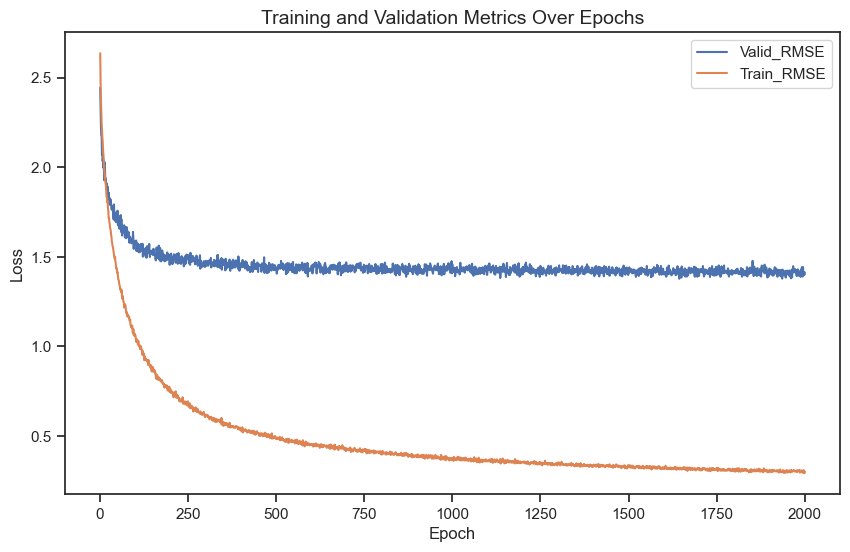

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [12]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.296855,0.296564,0.403200,0.403200,0.894316,0.945685,0.307493,NaN,1.406184,0.858710,0.858710,0.469980,0.691057,0.626926,0.470191,0.894316,1.403393
1996,1997,0.309168,0.309157,0.409200,0.409200,0.889828,0.943310,0.314509,NaN,1.399526,0.850578,0.850578,0.472490,0.693094,0.606008,0.472537,0.889831,1.396482
1997,1998,0.295858,0.295992,0.402576,0.402576,0.894519,0.945791,0.310445,NaN,1.406646,0.851032,0.851032,0.469806,0.690642,0.602128,0.470731,0.894519,1.403792
1998,1999,0.291770,0.291917,0.401329,0.401329,0.895971,0.946558,0.309108,NaN,1.416078,0.848677,0.848677,0.466251,0.687803,0.589721,0.466862,0.895972,1.413261
1999,2000,0.301468,0.301296,0.405898,0.405898,0.892629,0.944791,0.313213,NaN,1.401844,0.849134,0.849134,0.471616,0.692239,0.603427,0.472095,0.892629,1.398176
